# Capstone Project: Police Call Outcome Prediction

This notebook explores and analyzes police call data with the goal of predicting outcomes like arrests or citations. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [6]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import os

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2021 from the CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [8]:
year = "2021"
years = [2021]

# Ensure the directory exists
os.makedirs(f"models/{year}", exist_ok=True)

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 302119


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [11]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
177216,20210801015343PD,8715074,8/4/2021 12:00:00 AM,P212130096,2,8/1/2021 12:00:00 AM,8/1/2021 12:00:00 AM,01:38:11,415,DISTURBANCE,N,No report required; dispatch record only,BALBACH ST & ALMADEN AV,San Jose,CA,37.324434,-121.885236,Guadalupe Washington
2351,20210104014247PS,8448409,5/15/2021 12:00:00 AM,P210040054,6,1/4/2021 12:00:00 AM,1/4/2021 12:00:00 AM,01:28:13,1195X,VEHICLE STOP ON FEMALE,N,No report required; dispatch r,MONTEREY RD & UMBARGER RD,San Jose,CA,37.306949,-121.857135,Spartan Keyes and Wool Creek
236001,20211011120939PD,8809067,10/11/2021 12:00:00 AM,P212840278,3,10/11/2021 12:00:00 AM,10/11/2021 12:00:00 AM,09:41:50,246,SHOOTING INTO OCCP VEH OR DWELLING,N,No report required; dispatch record only,[600]-[700] SHEARTON DR,San Jose,CA,37.313861,-121.961651,Winchester Lynnhaven
172603,20210729214503PD,8712061,7/29/2021 12:00:00 AM,P212100856,2,7/29/2021 12:00:00 AM,7/29/2021 12:00:00 AM,20:57:43,415F,"DISTURBANCE, FAMILY",N,No report required; dispatch record only,[1900]-[2000] FRUITDALE AV,San Jose,CA,37.310705,-121.919062,Fruitdale and Sherman Oaks
178842,20210806000937PD,8721553,8/5/2021 12:00:00 AM,P212171055,4,8/5/2021 12:00:00 AM,8/5/2021 12:00:00 AM,23:46:35,415,DISTURBANCE,N,No report required; dispatch record only,[4400]-[4500] BLACKFORD AV,San Jose,CA,37.314406,-121.985235,Blackford


In [12]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302119 entries, 0 to 302118
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              302119 non-null  object 
 1   EID               302119 non-null  int64  
 2   START_DATE        302119 non-null  object 
 3   CALL_NUMBER       302119 non-null  object 
 4   PRIORITY          302119 non-null  int64  
 5   REPORT_DATE       302119 non-null  object 
 6   OFFENSE_DATE      302119 non-null  object 
 7   OFFENSE_TIME      302119 non-null  object 
 8   CALLTYPE_CODE     302119 non-null  object 
 9   CALL_TYPE         302119 non-null  object 
 10  FINAL_DISPO_CODE  302119 non-null  object 
 11  FINAL_DISPO       302119 non-null  object 
 12  ADDRESS           293112 non-null  object 
 13  CITY              302119 non-null  object 
 14  STATE             302119 non-null  object 
 15  LATITUDE          271738 non-null  float64
 16  LONGITUDE         27

In [13]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,3.021190e+05,302119.000000,271738.000000,271738.000000
mean,8.678600e+06,3.295503,37.322424,-121.871670
std,1.346496e+05,1.428692,0.042060,0.047263
min,8.444832e+06,1.000000,37.150332,-122.035696
25%,8.561760e+06,2.000000,37.300726,-121.902843
50%,8.677855e+06,3.000000,37.325134,-121.869952
75%,8.795038e+06,4.000000,37.349308,-121.838998
max,8.912981e+06,6.000000,37.534539,-121.635696


In [18]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,302119,302119,302119,302119,302119,302119,302119,302119,302119,302119,293112,302119,302119,270320
unique,300224,217,295467,365,365,80765,202,218,22,25,40145,1,1,295
top,20210812184930PD,5/15/2021 12:00:00 AM,P212140570,7/4/2021 12:00:00 AM,7/4/2021 12:00:00 AM,10:39:10,1195,VEHICLE STOP,N,No report required; dispatch record only,Not a valid geographical location in CAD.,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,109325,5,1116,1116,16,32837,32837,140203,88336,798,302119,302119,8807


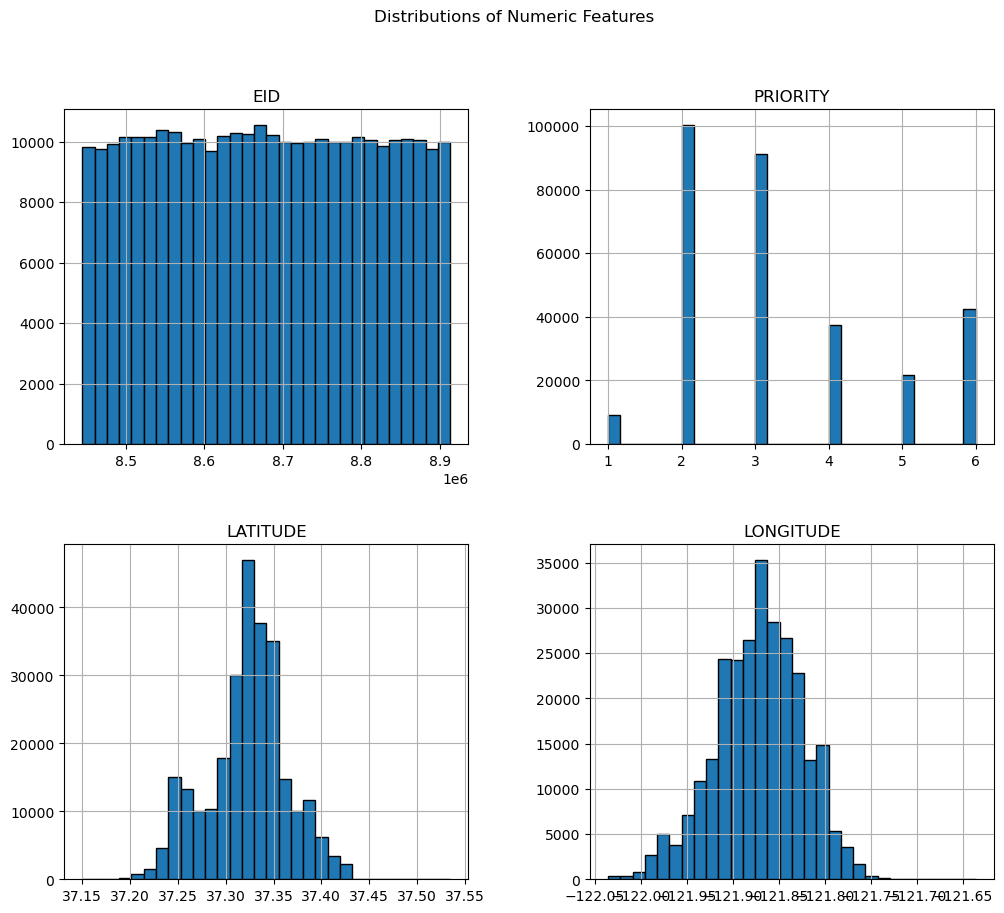

In [19]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [20]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              9007
CITY                    0
STATE                   0
LATITUDE            30381
LONGITUDE           30381
neighborhood        31799
dtype: int64

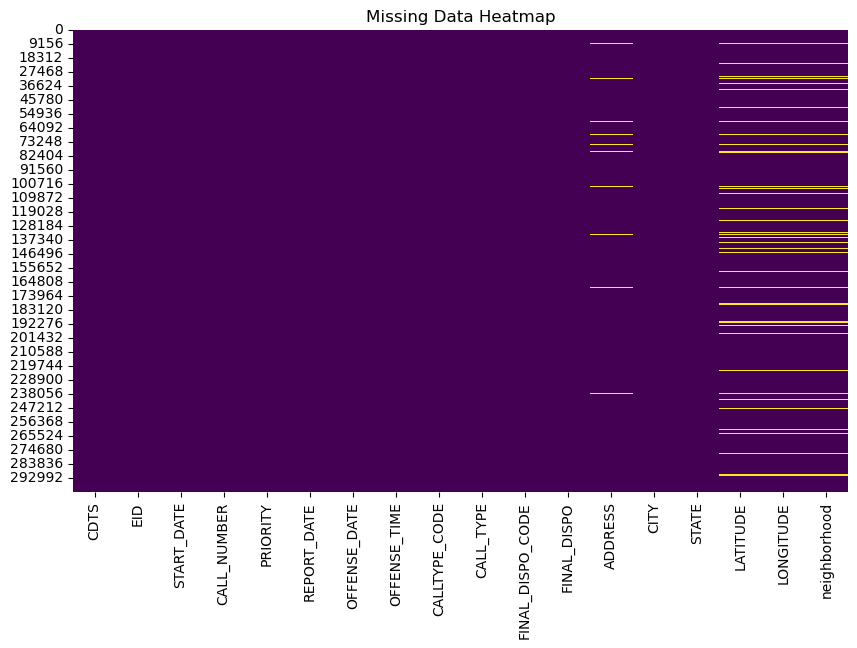

In [22]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [23]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 300224 unique values
START_DATE: 217 unique values
CALL_NUMBER: 295467 unique values
REPORT_DATE: 365 unique values
OFFENSE_DATE: 365 unique values
OFFENSE_TIME: 80765 unique values
CALLTYPE_CODE: 202 unique values
CALL_TYPE: 218 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 25 unique values
ADDRESS: 40145 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [26]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8807
Little Saigon and Spring Brook    5185
Five Wounds-San Jose High         4495
Trimble Business Area             4415
Virginia and Martha               3913
                                  ... 
Houge Parker                        43
Santa Teresa Hills                  30
Alta Vista                          29
Linda Vista and Hillcrest           25
Meadowlands                         20
Name: count, Length: 295, dtype: int64

In [27]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          140203
CAN         53453
R           32358
G           16690
D           13256
O            5969
DUPNCAN      5401
E            5075
GD           4901
A            4272
U            3977
H            3599
T            3072
C            2639
ADV          2523
B            2311
NR           1446
F             854
M              46
Z              42
TOT            16
P              16
Name: count, dtype: int64

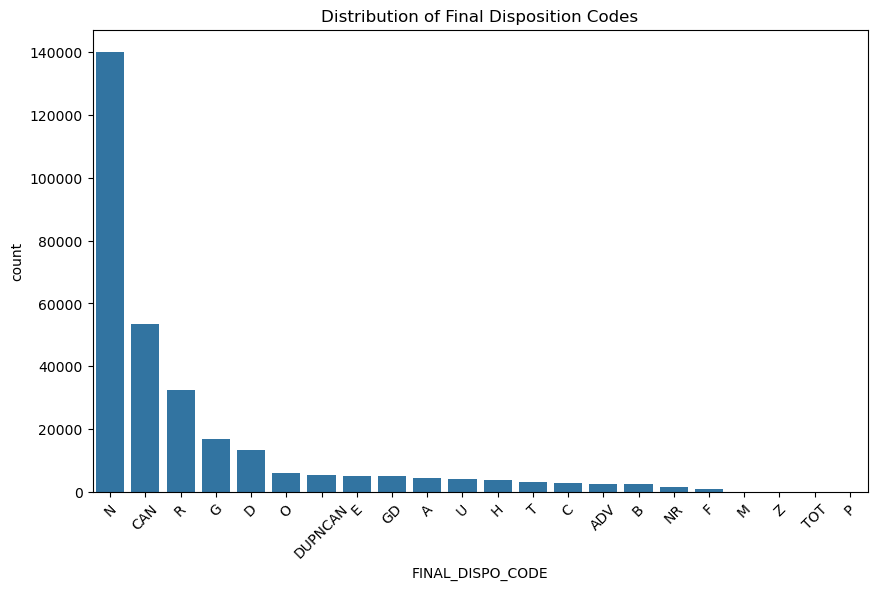

In [28]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [29]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch record only            88336
Canceled                                            53453
No report required; dispatch r                      51867
Report taken                                        32358
No Disposition                                      12883
Gone on Arrival/unable to locate                    10327
Traffic Citation Issued, Hazardous Violation         9266
Gone on Arrival/unable to loca                       6363
Supplemental report taken                            5969
Arrest Made                                          4272
Traffic Citation Issued, Hazar                       3990
Unfounded event                                      3977
Traffic Citation Issued, Non-Hazardous Violation     3236
Turned over To (TOT)                                 3072
Criminal Citation                                    2639
Arrest by Warrant                                    2311
Courtesy Service/Citizen or agency assist            2161
Tr

In [30]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'CAN': 'Canceled',
 'NR': 'No Response',
 'N': 'No report required; dispatch record only',
 'T': 'Turned over To (TOT)',
 'R': 'Report taken',
 'G': 'Gone on Arrival/unable to locate',
 'DUPNCAN': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'O': 'Supplemental report taken',
 'A': 'Arrest Made',
 'U': 'Unfounded event',
 'GD': 'No Disposition',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'H': 'Courtesy Service/Citizen or agency assist',
 'F': 'Field Interview (F.I.) Completed',
 'C': 'Criminal Citation',
 'B': 'Arrest by Warrant',
 'ADV': 'No Disposition',
 'Z': 'No Disposition',
 'M': 'Stranded motorist assist',
 'TOT': 'No Disposition',
 'P': 'Prior case, follow-up activity only'}

In [31]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'415FC': 'DISTURBANCE, FIRECRACKERS',
 '602PC': 'TRESPASSING',
 '1033A': 'ALARM, AUDIBLE',
 '1057': 'FIREARMS DISCHARGED',
 '1033S': 'ALARM, SILENT',
 '415F': 'DISTURBANCE, FAMILY',
 '415': 'DISTURBANCE',
 '1062': 'MEET THE CITIZEN',
 '415M': 'DISTURBANCE, MUSIC',
 '242': 'BATTERY',
 '1195': 'VEHICLE STOP',
 '415W': 'DISTURBANCE, WEAPON',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '415EMS': 'DISTURBANCE (COMBINED EVENT)',
 '1066': 'SUSPICIOUS PERSON',
 '245': 'ASSAULT WITH DEADLY WEAPON',
 '459': 'BURGLARY (460)',
 '415A': 'DISTURBANCE, FIGHT',
 '647': 'VAGRANT',
 '10851': 'STOLEN VEHICLE',
 '415UNK': 'DISTURBANCE, UNKNOWN',
 'DVRO': 'VIOLATION OF PROTECTIVE ORDER',
 '417': 'BRANDISHING A WEAPON',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 '22500': 'PARKING VIOLATION',
 '1154': 'SUSPICIOUS VEHICLE',
 'WELCK': 'WELFARE CHECK',
 '1067X': 'FEMALE CALLING FOR HELP',
 '459VEH': 'VEHICLE BURGLARY',
 '422': 'CRIMINAL THREATS',
 '1046': 'SICK PERSON',
 '

## Focus on Target Dispositions

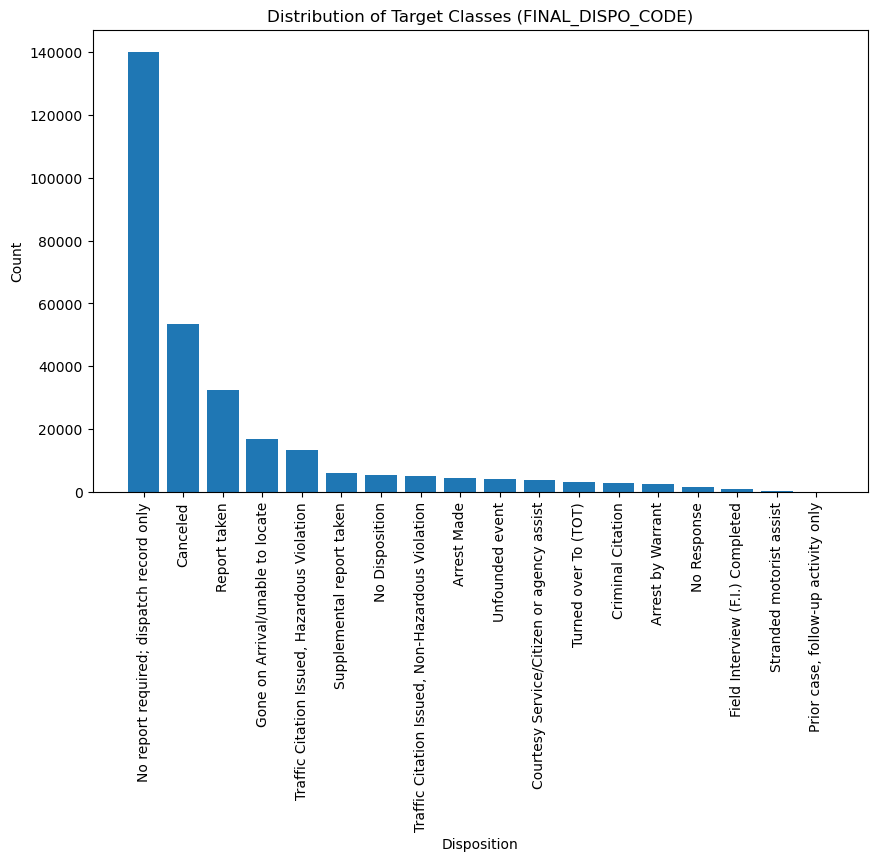

In [33]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [34]:
model_utils.transform_offense_date(all_police_df)

In [36]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    292897
A          4272
C          2639
B          2311
Name: count, dtype: int64

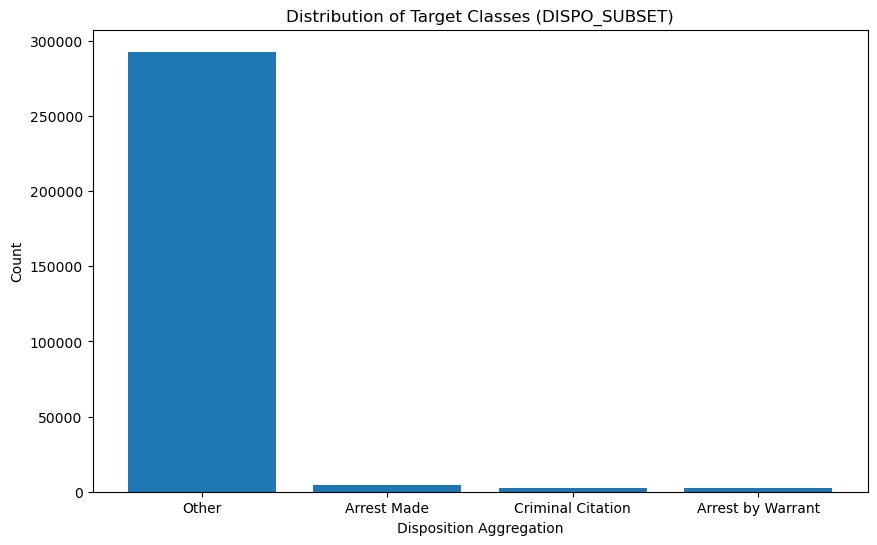

In [37]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.show()

## Data Cleaning and Feature Engineering

In [44]:
encoder = joblib.load('one_hot_encoder.pkl')

In [48]:
police_calls_encoded, _ = model_utils.clean_and_transform_data(all_police_df, encoder)
police_calls_encoded.shape

Police Calls Dataset: 302119 rows before cleaning, 270320 rows after cleaning.


(270320, 535)

## Define X and Y

In [54]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled = \
    model_utils.split_data(police_calls_encoded, dispo_mapping)

classes = ['A' 'B' 'C' 'Other']
(216256, 534)
(54064, 534)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 209536, 0: 3125, 2: 1890, 1: 1705})
Counter({3: 6720, 0: 3125, 2: 1890, 1: 1705})


y_train distribution: Counter({3: 209536, 0: 3125, 2: 1890, 1: 1705})
y_test distribution: Counter({3: 52384, 0: 781, 2: 473, 1: 426})
y_train_resampled distribution: Counter({3: 209536, 0: 3125, 2: 1890, 1: 1705})


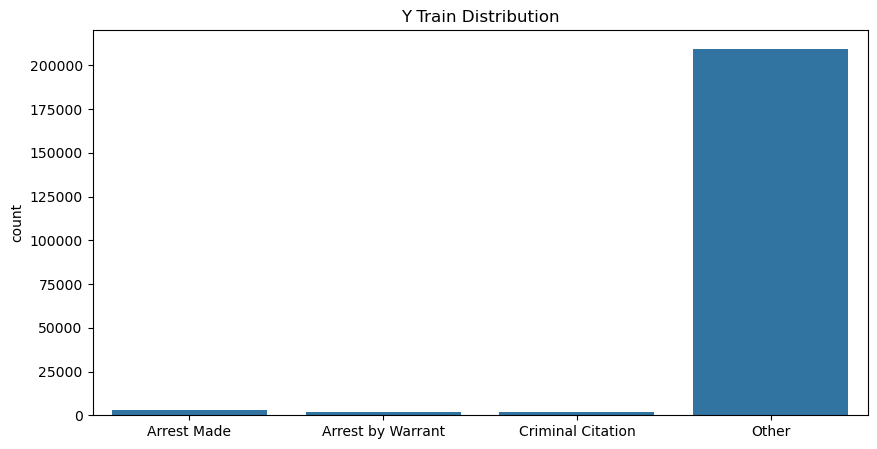

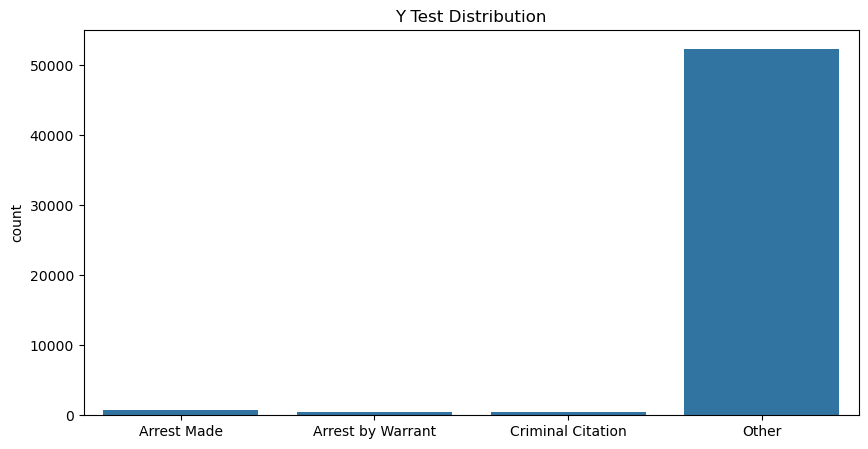

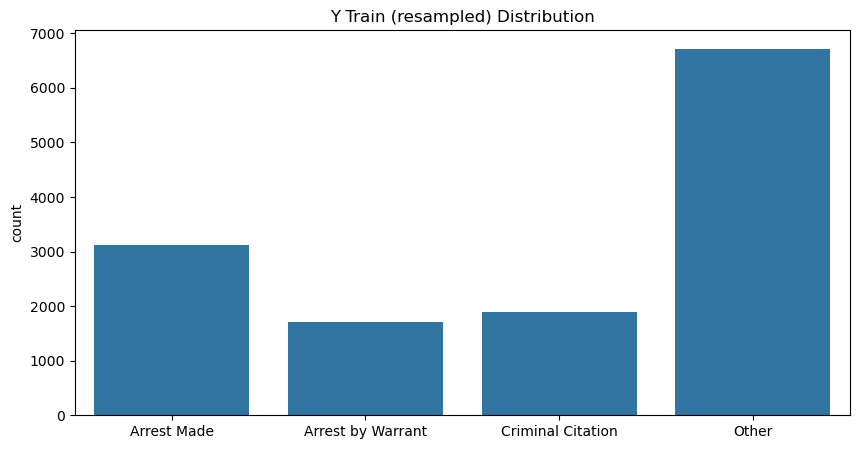

In [55]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [58]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [60]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [61]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00       781
Arrest by Warrant       0.00      0.00      0.00       426
Criminal Citation       0.00      0.00      0.00       473
            Other       0.97      1.00      0.98     52384

         accuracy                           0.97     54064
        macro avg       0.24      0.25      0.25     54064
     weighted avg       0.94      0.97      0.95     54064



### Logistic Regression

In [63]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [64]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [65]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.12      0.61      0.20       781
Arrest by Warrant       0.34      0.56      0.42       426
Criminal Citation       0.16      0.55      0.24       473
            Other       0.99      0.90      0.94     52384

         accuracy                           0.89     54064
        macro avg       0.40      0.66      0.45     54064
     weighted avg       0.97      0.89      0.92     54064



#### Hyperparameter Tuning

In [68]:
grid_search_scoring_method = 'f1_macro'

In [69]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

# Initialize Grid Search
# make sure n_jobs is reasonable so my machine doesn't run out of memory
grid_lr = GridSearchCV(estimator=lr_model, param_grid=param_grid_lr, 
                              cv=5, n_jobs=3, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=3, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [74]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 0.1}
Best Score (f1_macro): 0.5541


In [75]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2021/best_logistic_regression.pkl']

In [76]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [77]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.56      0.22      0.31       781
Arrest by Warrant       0.61      0.52      0.56       426
Criminal Citation       0.54      0.26      0.35       473
            Other       0.98      1.00      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.67      0.50      0.55     54064
     weighted avg       0.97      0.97      0.97     54064



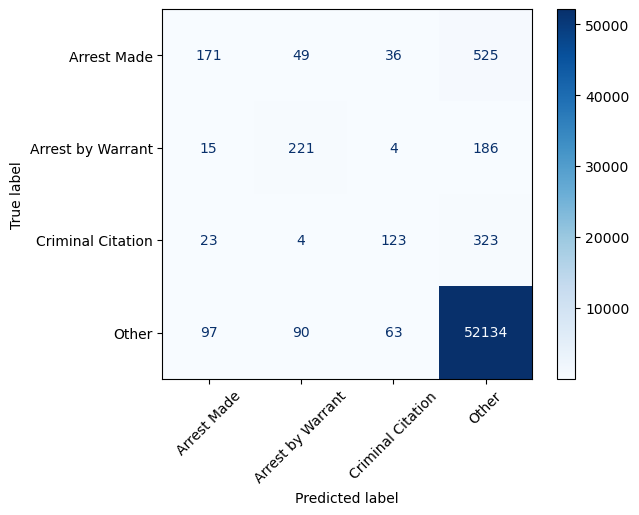

In [78]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [80]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [81]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [82]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                          Feature  Importance  \
204                              CALLTYPE_CODE_6F    0.003823   
64                            CALLTYPE_CODE_11300    0.003021   
205                              CALLTYPE_CODE_6M    0.002898   
69                            CALLTYPE_CODE_11377    0.001480   
112                           CALLTYPE_CODE_23152    0.001449   
85                            CALLTYPE_CODE_12020    0.000987   
49                           CALLTYPE_CODE_10851R    0.000863   
0                                        PRIORITY    0.000771   
136                            CALLTYPE_CODE_3056    0.000647   
58                             CALLTYPE_CODE_1095    0.000617   
231                            CALLTYPE_CODE_DVRO    0.000617   
165                             CALLTYPE_CODE_459    0.000586   
66                            CALLTYPE_CODE_11350    0.000555   
88                            CALLTYPE_CODE_12500    0.000493   
146                      

In [83]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                          Display Name  Coefficient
49                 Call Type: RECOVERED STOLEN VEHICLE     0.364109
13                           Call Type: ALARM, AUDIBLE    -0.282365
107                       Call Type: PARKING VIOLATION    -0.259359
112                         Call Type: MISDEMEANOR DUI     0.234923
231           Call Type: VIOLATION OF PROTECTIVE ORDER     0.226089
146                     Call Type: DISTURBANCE, FAMILY     0.215916
153                      Call Type: DISTURBANCE, MUSIC    -0.215215
165                          Call Type: BURGLARY (460)     0.213400
47                           Call Type: STOLEN VEHICLE     0.198005
212                       Call Type: UNK TYPE 911 CALL    -0.182942
238                           Call Type: WELFARE CHECK    -0.180890
125              Call Type: ASSAULT WITH DEADLY WEAPON     0.178193
185                      Call Type: MALICIOUS MISCHIEF     0.164013
0                          

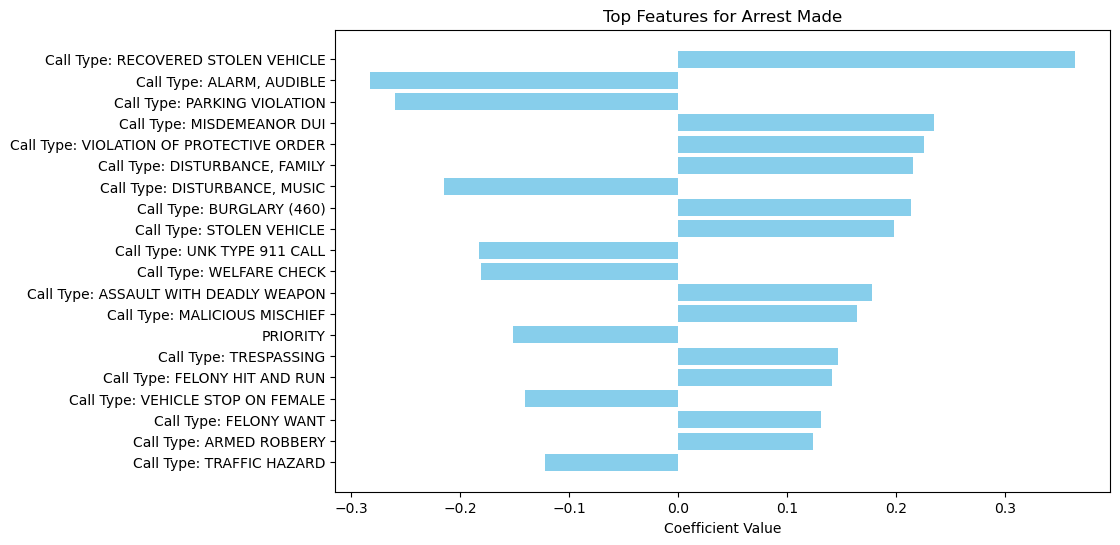

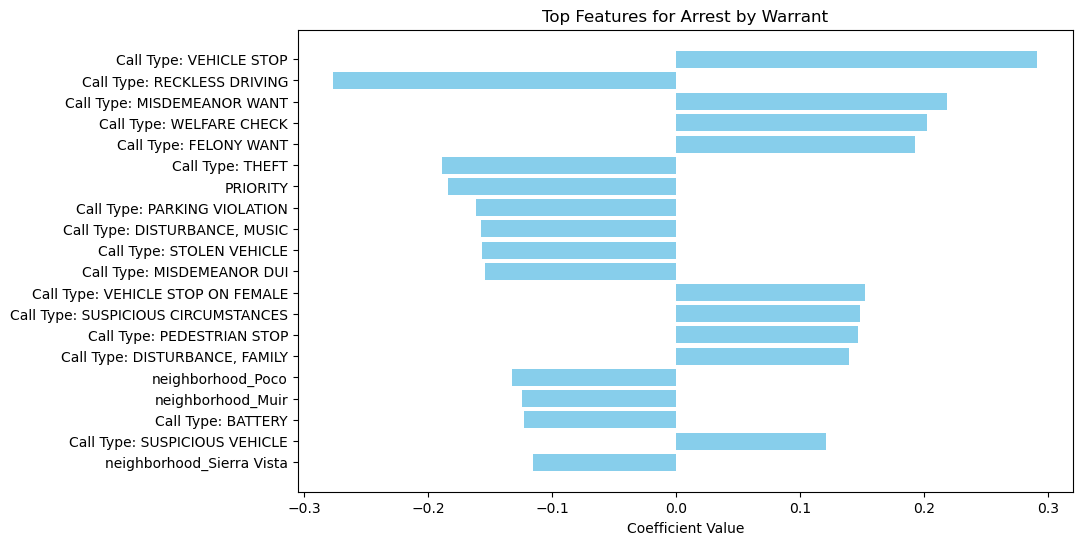

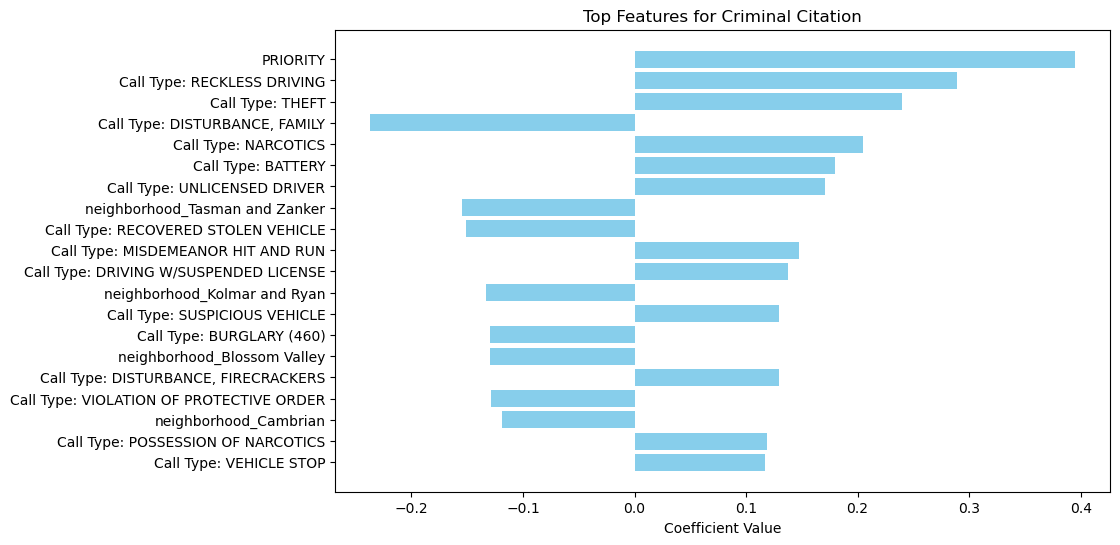

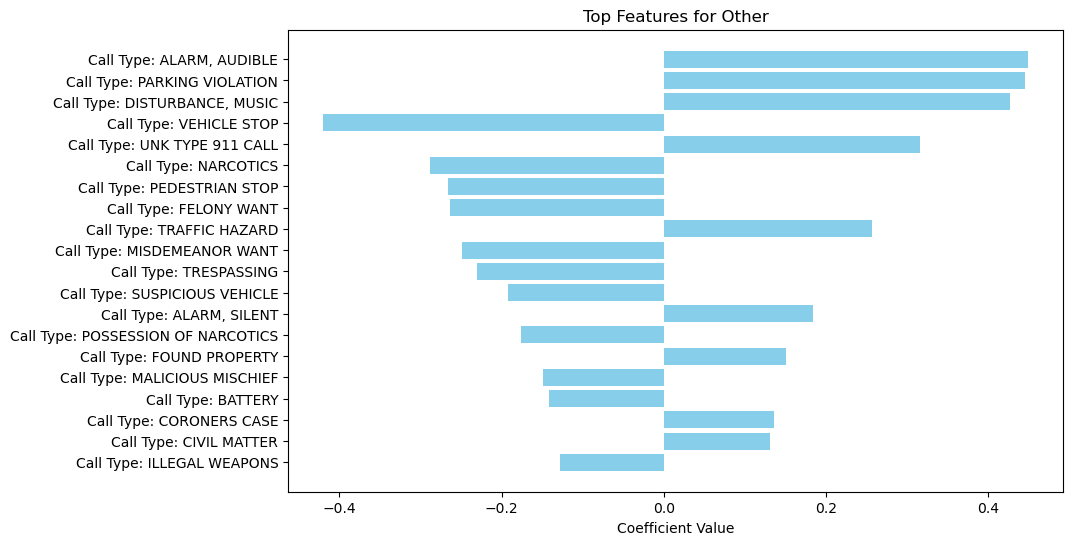

In [84]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [86]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [87]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.40      0.20      0.27       781
Arrest by Warrant       0.55      0.44      0.49       426
Criminal Citation       0.43      0.25      0.31       473
            Other       0.98      0.99      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.59      0.47      0.51     54064
     weighted avg       0.96      0.97      0.97     54064



#### Hyperparameter Tuning and Cross Validation

In [89]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=5,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.53


In [90]:
best_rf = grid_rf.best_estimator_

In [91]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2021/best_random_forest.pkl']

In [94]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [97]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.42      0.22      0.29       781
Arrest by Warrant       0.54      0.43      0.48       426
Criminal Citation       0.42      0.24      0.30       473
            Other       0.98      0.99      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.59      0.47      0.51     54064
     weighted avg       0.96      0.97      0.97     54064



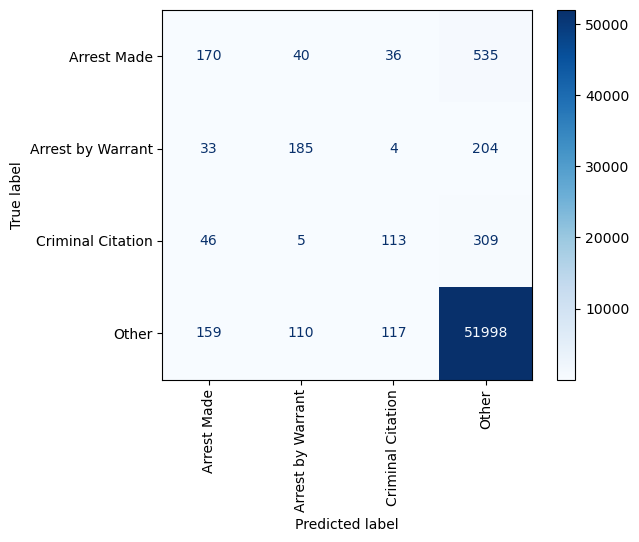

In [98]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

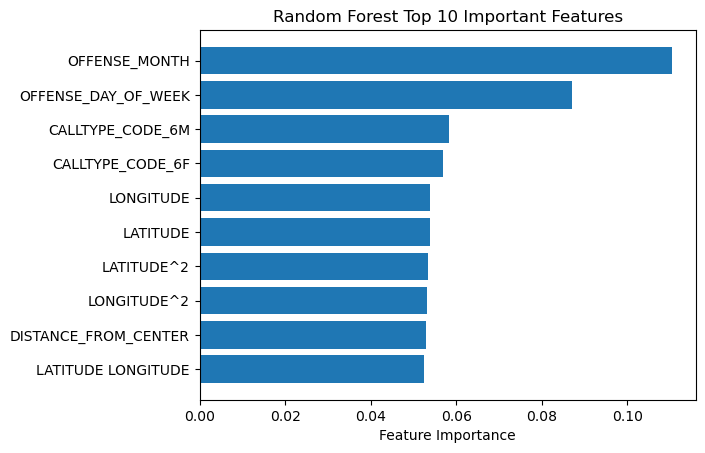

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('Random Forest Top 10 Important Features')
plt.show()

### Multilayer Perceptron Model

In [102]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

In [103]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=5,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [104]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [105]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9681 - loss: 0.1518 - val_accuracy: 0.9726 - val_loss: 0.1050
Epoch 2/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9727 - loss: 0.1083 - val_accuracy: 0.9730 - val_loss: 0.1083
Epoch 3/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9727 - loss: 0.1050 - val_accuracy: 0.9711 - val_loss: 0.1067
Epoch 4/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9721 - loss: 0.1032 - val_accuracy: 0.9722 - val_loss: 0.1062
Epoch 5/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9738 - loss: 0.0975 - val_accuracy: 0.9726 - val_loss: 0.1064
Epoch 6/20
2704/2704 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9742 - loss: 0.0948 - val_accuracy: 0.9727 - val_loss: 0.1053


In [106]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2021/mlp_model.pkl']

In [107]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [108]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1690/1690 ━━━━━━━━━━━━━━━━━━━━ 1s 469us/step - accuracy: 0.9717 - loss: 0.1087
Test Accuracy: 0.9721


In [109]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1690/1690 ━━━━━━━━━━━━━━━━━━━━ 1s 460us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.49      0.23      0.31       781
Arrest by Warrant       0.60      0.55      0.57       426
Criminal Citation       0.41      0.11      0.17       473
            Other       0.98      0.99      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.62      0.47      0.51     54064
     weighted avg       0.96      0.97      0.97     54064



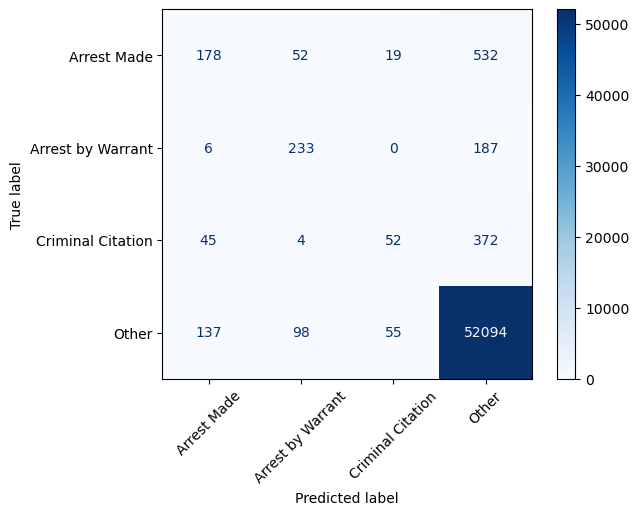

In [110]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [113]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-04 12:59:03,993] A new study created in memory with name: no-name-57d88437-ba57-42a2-8256-7fe556140af0
[I 2024-10-04 12:59:14,177] Trial 0 finished with value: 0.678439166583345 and parameters: {'n_estimators': 246, 'learning_rate': 0.07911244364550489, 'max_depth': 4, 'subsample': 0.7060137954260046, 'colsample_bytree': 0.7384059021007227, 'gamma': 4.431864397799324e-08, 'reg_alpha': 0.00042015887088052726, 'reg_lambda': 3.0578704900699694e-07}. Best is trial 0 with value: 0.678439166583345.
[I 2024-10-04 12:59:35,233] Trial 1 finished with value: 0.6458309867658072 and parameters: {'n_estimators': 412, 'learning_rate': 0.213652011712295, 'max_depth': 7, 'subsample': 0.9452188994335069, 'colsample_bytree': 0.6800229732538059, 'gamma': 2.3213120971505786e-06, 'reg_alpha': 8.330486035040966e-05, 'reg_lambda': 0.00011062328113297145}. Best is trial 0 with value: 0.678439166583345.
[I 2024-10-04 12:59:57,704] Trial 2 finished with value: 0.6756771327061897 and parameters: {'n_e

Actual runtime: 382.84 seconds (6.38 minutes)
Best parameters found:  {'n_estimators': 246, 'learning_rate': 0.07911244364550489, 'max_depth': 4, 'subsample': 0.7060137954260046, 'colsample_bytree': 0.7384059021007227, 'gamma': 4.431864397799324e-08, 'reg_alpha': 0.00042015887088052726, 'reg_lambda': 3.0578704900699694e-07}
Best F1 macro score:  0.678439166583345


In [114]:
# Train the final model with the best parameters:
best_params = study.best_params
best_model = XGBClassifier(**best_params, eval_metric='logloss')
best_model.fit(X_train, y_train)
xgb_1_model = best_model
xgb_1_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7384059021007227, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.431864397799324e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.07911244364550489, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=246, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [115]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.62      0.19      0.29       781
Arrest by Warrant       0.61      0.54      0.57       426
Criminal Citation       0.55      0.24      0.33       473
            Other       0.98      1.00      0.99     52384

         accuracy                           0.97     54064
        macro avg       0.69      0.49      0.55     54064
     weighted avg       0.97      0.97      0.97     54064



In [116]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2021/xgb_model.pkl']

In [117]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [119]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [120]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5534719489949091
RF F1: 0.5148885342895255
XGB F1: 0.546809820654365


In [121]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

#### Stacking #1

In [123]:
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), n_jobs=5)
stacking_clf.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7384059021007227,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                              learning_rate=0.07911244364550489,
                                              max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=4,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=246, n_jobs=None,
                                              num_parallel_tree=None,
                                              objective='multi:softprob', ...))],
                   final_estimator=LogisticRegression(), n_jobs=5)

In [124]:
joblib.dump(stacking_clf, f"models/{year}/stacking_1.pkl") 

['models/2021/stacking_1.pkl']

In [125]:
stacking_clf = joblib.load(f"models/{year}/stacking_1.pkl")

In [126]:
y_pred_stacking_1 = stacking_clf.predict(X_test)
stack_1_accuracy = accuracy_score(y_test, y_pred_stacking_1)
stack_1_recall = recall_score(y_test, y_pred_stacking_1, average='macro')
stack_1_prec = precision_score(y_test, y_pred_stacking_1, average='macro')
stack_1_f1 = f1_score(y_test, y_pred_stacking_1, average='macro')
print(f"Stacking Classifier F1 Score: {stack_1_f1}")

Stacking Classifier F1 Score: 0.5520136841251766


#### Stacking #2

In [128]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=5)
stacking_clf_2.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=0.1, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7384059021007227,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=5)

In [129]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2021/stacking_2.pkl']

In [130]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [131]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.56950130704083


## Results

In [133]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Stack 1', 'Stack 2'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.968926,0.250000,0.242231,0.246054
Logistic Regression,0.973827,0.498250,0.672692,0.553472
Random Forest,0.970442,0.470868,0.589887,0.514889
MLP,0.972126,0.469815,0.620148,0.511025
XGB,0.973846,0.492274,0.690962,0.546810
Stack 1,0.973716,0.494491,0.662810,0.552014
Stack 2,0.973901,0.520116,0.659997,0.569501


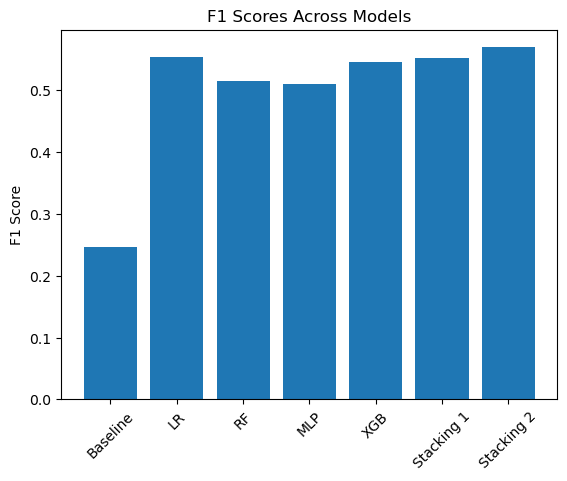

In [134]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Stacking 1', 'Stacking 2']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Compare with the All-Year Models

In [136]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [137]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

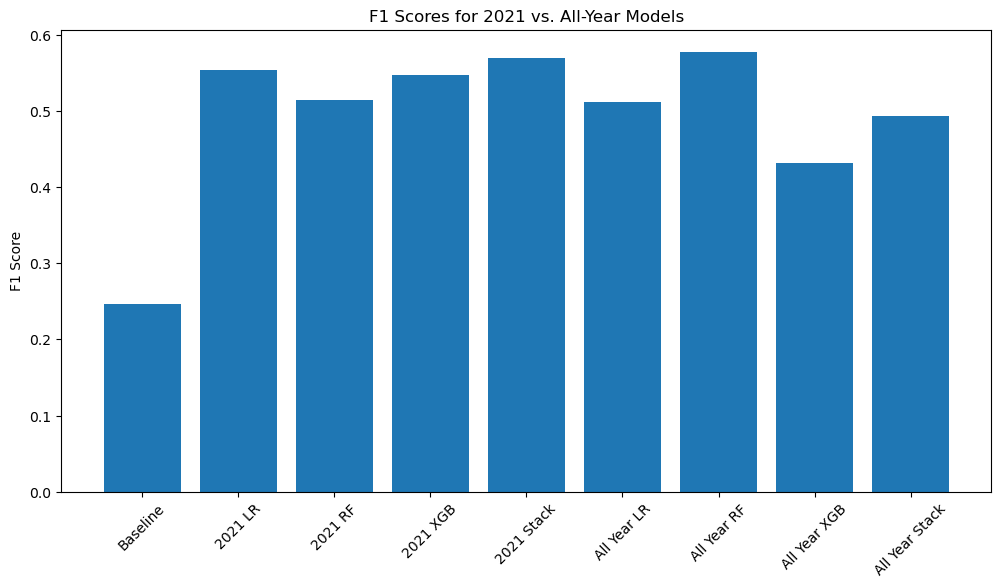

In [138]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()